In [71]:
import pandas as pd
import gurobipy 
from gurobipy import Model, GRB, quicksum
import numpy as np

#Loading the dataset 
brick_index_value = pd.read_csv('./bricks_index_values.csv')
brick_rp_distances = pd.read_csv('./brick_rp_distances.csv')
#distances= pd.read_csv('./distances.xlsx')
#pfizer =pd.read_csv('./Pfitzer10-100.csv', sep=';')

### 1. Objectif de minimisation de la distance

In [72]:
#Extracting data from the datasets
bricks = brick_index_value['brick'].tolist()
reps = list(range(1, 5))  # 4 représentants

#Converting distance to a dictionary f
distances = {
    row['brick']: [row[f'rp{i}'] for i in reps]
    for _, row in brick_rp_distances.iterrows()
}
#Converting index values to a dictionary
index_values = dict(zip(brick_index_value['brick'], brick_index_value['index_value']))

#Workload interval bounds
L = 0.8 
U = 1.2

#Modèle pour minimiser la distance
model_distance = Model("Minimize_Distance")

#Variables de décision 
#Variables binaires x[b, r], chaques briques b est assignée à un représentant r
x = model_distance.addVars(bricks, reps, vtype=GRB.BINARY, name="x") 

#Fonction objectif : minimiser la distance totale
model_distance.setObjective(
    quicksum(distances[b][r - 1] * x[b, r] for b in bricks for r in reps), GRB.MINIMIZE
)

#Chaque brique est assignée à un seul représentant
model_distance.addConstrs(
    (quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick"
)

#Contraintes de charge de travail dans l'intervalle [L, U]
model_distance.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload"
)

model_distance.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload"
)

#Optimisation
model_distance.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0x4ea169f8
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [8e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 353.0700000
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)



Root relaxation: objective 1.488198e+02, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  148.81982    0    6  353.07000  148.81982  57.8%     -    0s
H    0     0                     180.9600000  148.81982  17.8%     -    0s
H    0     0                     154.6200000  148.81982  3.75%     -    0s
     0     0  148.81982    0    6  154.62000  148.81982  3.75%     -    0s

Explored 1 nodes (25 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 154.62 180.96 353.07 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.546200000000e+02, best bound 1.546200000000e+02, gap 0.0000%


In [73]:
# Affichage des résultats sous forme de tableau
if model_distance.Status == GRB.OPTIMAL:
    print("\nDistance totale minimale :", model_distance.ObjVal)
    results = []
    for b in bricks:
        for r in reps:
            if x[b, r].X > 0.5:
                results.append([b, r])

    # Création du DataFrame pour afficher les résultats
    results_df = pd.DataFrame(
        results, columns=['Brick', 'Représentant'])

results_df[['Brick', 'Représentant']]



Distance totale minimale : 154.62


,Brick,Représentant
0,1,4
1,2,4
2,3,4
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,1
9,10,3


### 2. Objectif minimisation de disruption

In [74]:
#Assignation initiale des briques aux représentants
initial_assignment = {
    4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 15: 1,   # SR 1
    10: 2, 11: 2, 12: 2, 13: 2, 14: 2,     # SR 2
    9: 3, 16: 3, 17: 3, 18: 3,             # SR 3
    1: 4, 2: 4, 3: 4, 19: 4, 20: 4, 21: 4, 22: 4  # SR 4
}

#Modèle pour minimiser la perturbation
model_disruption = Model("Minimize_Disruption")

#Variables de décision
x = model_disruption.addVars(bricks, reps, vtype=GRB.BINARY, name="x")
y = model_disruption.addVars(bricks, reps, vtype=GRB.BINARY, name="y")

#Fonction objectif : minimiser la perturbation pondérée par l'index
model_disruption.setObjective(
    quicksum(index_values[b] * y[b, r] for b in bricks for r in reps), GRB.MINIMIZE
)

#Contraintes
#Chaque brick doit être attribué à un seul représentant
model_disruption.addConstrs(
    (quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick"
)

#Charge de travail dans l'intervalle [L, U]
model_disruption.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload"
)
model_disruption.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload"
)

#Mesurer la perturbation
model_disruption.addConstrs(
    (y[b, r] >= x[b, r] - (1 if initial_assignment[b] == r else 0)
     for b in bricks for r in reps), name="Disruption"
)

#Résoudre le modèle
model_disruption.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 118 rows, 176 columns and 440 nonzeros
Model fingerprint: 0xa736d90c
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 2.6088000
Presolve removed 88 rows and 88 columns
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.377000e-01, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/No

In [75]:
# Afficher les résultats sous forme de tableau
if model_disruption.Status == GRB.OPTIMAL:
    print("\nPerturbation totale minimale :", model_disruption.ObjVal)
    results = []
    for b in bricks:
        for r in reps:
            if x[b, r].X > 0.5:
                results.append([b, r])

    # Création du DataFrame pour afficher les résultats
    results_df = pd.DataFrame(results, columns=['Brick', 'Représentant'])

results_df[['Brick', 'Représentant']]


Perturbation totale minimale : 0.1696


,Brick,Représentant
0,1,4
1,2,4
2,3,4
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,3
9,10,2


### 3. Epsilon Constraint

In [76]:
# Fonction pour déterminer les center bricks
def determine_center_bricks_from_distances(distances, reps):
    center_bricks = {}
    for r in reps:
        center_brick = min(
            distances.keys(), key=lambda b: distances[b][r - 1]
        )  # Trouver la brique la plus proche du centre pour chaque représentant

        center_bricks[r] = center_brick
    return center_bricks


# Fonction pour extraire la solution
def extract_solution(model, bricks, reps):
    assignment = {r: [] for r in reps}  # Initialiser les assignations
    assigned_bricks = set()  # Pour vérifier les doublons

    for b in bricks:
        assigned_rep = None
        for r in reps:
            var = model.getVarByName(f"x[{b},{r}]")
            if (
                var and var.x > 0.5
            ):  # Vérifier si la brique est assignée au représentant
                if b in assigned_bricks:
                    print(f"Warning: Brick {b} assigned to multiple representatives!")
                else:
                    assignment[r].append(b)
                    assigned_bricks.add(b)
                    assigned_rep = r
        if assigned_rep is None:
            print(f"Warning: Brick {b} not assigned to any representative!")

    return assignment


Initial maximum distance: 244.65

Solving for workload constraints: [0.8, 1.2]
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 119 rows, 176 columns and 524 nonzeros
Model fingerprint: 0x00392e93
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+01]
  Objective range  [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 2e+02]
Found heuristic solution: objective 1.8370000
Presolve removed 88 rows and 88 columns
Presolve time: 0.01s
Presolved: 31 rows, 88 columns, 330 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.377000e-01, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      

Solution found: Distance = 188.89000000000004, Disruption = 0.1696
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 119 rows, 176 columns and 524 nonzeros
Model fingerprint: 0x90c020fe
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+01]
  Objective range  [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 2e+02]
Found heuristic solution: objective 2.9531000
Presolve removed 88 rows and 88 columns
Presolve time: 0.00s
Presolved: 31 rows, 88 columns, 330 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.377000e-01, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 E

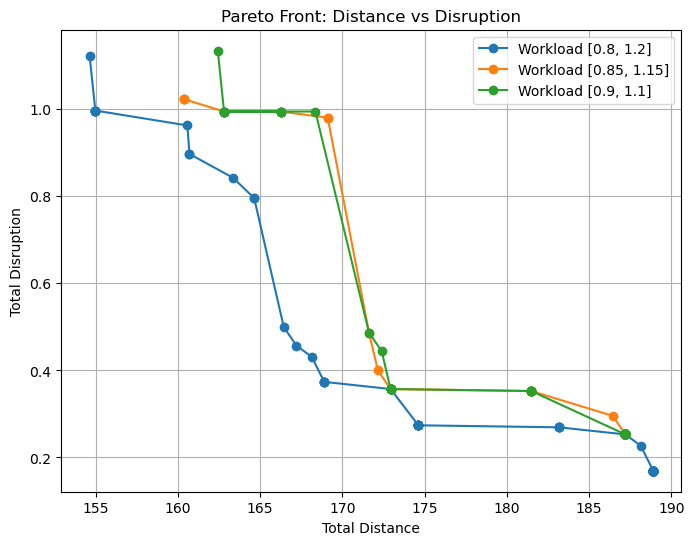

In [77]:
import matplotlib.pyplot as plt

#Workload bounds to test
workload_bounds = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]

def epsilon_constraint_scheme(initial_assignment, max_distance, workload_bounds):
    pareto_solutions = []
    epsilon = max_distance  #Initial upper bound for distance
    epsilon_step = 1  #Step to decrease epsilon

    #Iterate over different workload constraints
    for L, U in workload_bounds:
        print(f"\nSolving for workload constraints: [{L}, {U}]")
        epsilon = max_distance  #Reset epsilon for each workload bound

        #Start epsilon-constraint loop
        while epsilon >= 0:
            #Define model
            model = Model("Epsilon_Constraint")

            #Decision variables
            x = model.addVars(bricks, reps, vtype=GRB.BINARY, name="x")
            y = model.addVars(bricks, reps, vtype=GRB.BINARY, name="y")

            #Objectives
            total_distance = quicksum(distances[b][r - 1] * x[b, r] for b in bricks for r in reps)
            total_disruption = quicksum(index_values[b] * y[b, r] for b in bricks for r in reps)

            #Objective: minimize disruption
            model.setObjective(total_disruption, GRB.MINIMIZE)

            #Constraints
            model.addConstrs((quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick")
            model.addConstr(total_distance <= epsilon, name="Epsilon_Distance")
            model.addConstrs((y[b, r] >= x[b, r] - (1 if initial_assignment.get(b, None) == r else 0)
                              for b in bricks for r in reps), name="Disruption")
            model.addConstrs((quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload")
            model.addConstrs((quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload")

            #Optimize the model
            model.optimize()

            #Check feasibility and store solutions
            if model.Status == GRB.OPTIMAL:
                solution_distance = total_distance.getValue()
                solution_disruption = total_disruption.getValue()
                assignment = extract_solution(model, bricks, reps)
                pareto_solutions.append((L, U, solution_distance, solution_disruption,assignment))
                print(f"Solution found: Distance = {solution_distance}, Disruption = {solution_disruption}")
            else:
                print(f"No feasible solution for epsilon: {epsilon} and workload [{L}, {U}]")

            #Reduce epsilon
            epsilon -= epsilon_step

    return pareto_solutions

#Compute Pareto solutions
max_distance = sum(distances[b][0] for b in bricks) 
print(f"\nInitial maximum distance: {max_distance}")
pareto_solutions = epsilon_constraint_scheme(initial_assignment, max_distance, workload_bounds)

#Plot the set of non-dominated solutions
def plot_pareto_solutions(pareto_solutions):
    plt.figure(figsize=(8, 6))
    for L, U in set((L, U) for L, U, _, _, _ in pareto_solutions):
        subset = [(d, dis) for (lb, ub, d, dis, _) in pareto_solutions if lb == L and ub == U]
        distances, disruptions = zip(*subset)
        plt.plot(distances, disruptions, marker='o', linestyle='-', label=f"Workload [{L}, {U}]")
    plt.xlabel("Total Distance")
    plt.ylabel("Total Disruption")
    plt.title("Pareto Front: Distance vs Disruption")
    plt.legend()
    plt.grid(True)
    plt.show()

#Print the set of non-dominated solutions
print("\nSet of Non-Dominated Solutions:")
for L, U, distance, disruption, assignment in pareto_solutions:
    print(f"Workload [{L}, {U}] - Distance: {distance}, Disruption: {disruption}")

#Plot the Pareto front
plot_pareto_solutions(pareto_solutions)

#### Visualisation des solutions 

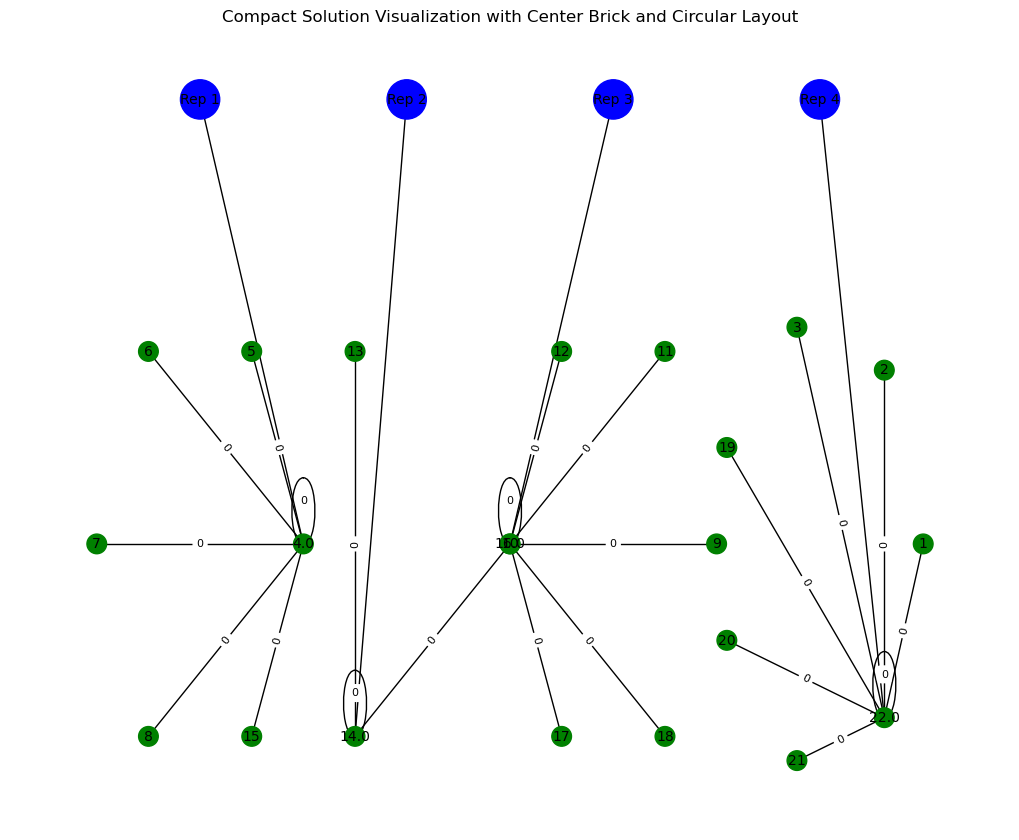

In [ ]:
import networkx as nx

import math

def visualize_solution_with_circles(solution, center_bricks, distances):
    G = nx.Graph()
    #Ajouter les center bricks et les arêtes
    for rep, center_brick in center_bricks.items():
        G.add_node(f"Rep {rep}", pos=(rep * 5, 5), color="blue", size=800)
        G.add_node(center_brick, pos=(rep * 5, 0), color="red", size=400)
        G.add_edge(f"Rep {rep}", center_brick)

    for rep, bricks in solution.items():
        center_brick = center_bricks[rep]
        num_bricks = len(bricks)
        angle_step = 2 * math.pi / max(num_bricks, 1)  #Angle entre chaque brique
        radius = 2.5  #Rayon du cercle compact

        for i, brick in enumerate(bricks):
            #Position circulaire compacte autour du center brick
            angle = i * angle_step
            x = rep * 5 + radius * math.cos(angle)
            y = radius * math.sin(angle)
            G.add_node(brick, pos=(x, y), color="green", size=200)
            G.add_edge(center_brick, brick, weight=distances.get((brick, rep), 0))

    pos = nx.get_node_attributes(G, "pos")
    colors = [G.nodes[n].get("color", "black") for n in G.nodes]
    sizes = [G.nodes[n].get("size", 100) for n in G.nodes]

    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=sizes, font_size=10)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.show()

#Déterminer les center bricks automatiquement
center_bricks = determine_center_bricks_from_distances(distances, reps)

#Visualiser la solution avec les center bricks
if pareto_solutions:
    _, _, _, _, solution = pareto_solutions[0] #Première solution
    visualize_solution_with_circles(solution, center_bricks, distances)

### 4. Test Instance 10-100

In [79]:
from scipy.spatial.distance import pdist, squareform

#Chargement des données
data = pd.read_csv('./Pfitzer10-100.csv', sep=';', decimal=',')
data.columns = [
    "zone", "x", "y", "workload_index", "current_office",
    "rp1", "rp2", "rp3", "rp4", "rp5", "rp6", "rp7", "rp8", "rp9", "rp10"
]

#Extraire les zones et représentants
bricks = data["zone"].tolist()
reps = list(range(1, 11)) 

#Calcul des distances entre chaque zone et les bureaux actuels des représentants
rep_positions = data[data["current_office"] == 1][["zone", "x", "y"]].set_index("zone")
coords = data[["x", "y"]].values
distances_matrix = squareform(pdist(coords))  # Matrice des distances

#Recalcul des distances entre chaque zone et les représentants
distances = {
    zone: [distances_matrix[zone - 1, rep - 1] for rep in rep_positions.index]
    for zone in bricks
}

#Dictionnaire des index de charge de travail
index_values = dict(zip(data["zone"], data["workload_index"]))

#Assignation initiale des zones aux représentants
initial_assignment = {
    zone: rep for rep, zone in enumerate(rep_positions.index, start=1)
}
#Vérification de l'assignation initiale
if len(initial_assignment) != len(reps):
    raise ValueError("Assignation initiale incomplète ! Vérifiez les représentants non affectés.")

In [80]:
max_distance = sum(max(distances[zone]) for zone in bricks)
print("Distance maximale :", max_distance)
pareto_solutions = epsilon_constraint_scheme(
    initial_assignment, max_distance, workload_bounds
)


print("\nSet of Non-Dominated Solutions:")
for L, U, distance, disruption in pareto_solutions:
    print(f"Workload [{L}, {U}] - Distance: {distance}, Disruption: {disruption}")

plot_pareto_solutions(pareto_solutions)


Distance maximale : 91.25521701523542

Solving for workload constraints: [0.8, 1.2]
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1121 rows, 2000 columns and 5990 nonzeros
Model fingerprint: 0x2b044b34
Variable types: 0 continuous, 2000 integer (2000 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-03, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 9e+01]
Found heuristic solution: objective 9.8084000
Presolve removed 1001 rows and 1000 columns
Presolve time: 0.01s
Presolved: 120 rows, 1000 columns, 3000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)

Root relaxation: objective 9.275100e+00, 168 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     

Solution found: Distance = 40.91992528951105, Disruption = 9.275100000000002
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1121 rows, 2000 columns and 5990 nonzeros
Model fingerprint: 0x92333d0d
Variable types: 0 continuous, 2000 integer (2000 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-03, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 7e+01]
Found heuristic solution: objective 9.8084000
Presolve removed 1000 rows and 1000 columns
Presolve time: 0.02s
Presolved: 121 rows, 1000 columns, 3900 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)

Root relaxation: objective 9.275100e+00, 156 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objecti

ValueError: too many values to unpack (expected 4)